In [1]:
include("XYCore.jl")
using .XYCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Logging, LinearAlgebra, Statistics, StatsBase, Random
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(XYCore))

[:XYCore, :calc_acceptance_and_rtt, :calc_energy, :calc_magnetization, :initial_state, :metropolis_sampler, :score_method, :wolff_sampler]


In [2]:
N = 20
β_min = 0.5
β_max = 2.0
M = 20
mcSteps=10^6
@info """
Hyperparameters of XY model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
β_ladder_trace = [[0.4821627673788133, 0.5403628311901534, 0.595876317809738, 0.6503784583108325, 0.7039759936043815, 0.7567735997540792, 0.806226067881303, 0.8562529921459816, 0.903446933216904, 0.9544403173614215, 1.008202298256743, 1.0741051224896925, 1.1480378119568255, 1.2342505871345222, 1.3297968100467674, 1.4373970511505032, 1.5574063919189038, 1.691842400182833, 1.8381096111929351, 2.0]]
geometric_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
inverse_linear_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:inverse_linear
)
push!(β_ladder_trace, geometric_β_ladder)
push!(β_ladder_trace, inverse_linear_β_ladder)

3-element Vector{Vector{Float64}}:
 [0.4821627673788133, 0.5403628311901534, 0.595876317809738, 0.6503784583108325, 0.7039759936043815, 0.7567735997540792, 0.806226067881303, 0.8562529921459816, 0.903446933216904, 0.9544403173614215, 1.008202298256743, 1.0741051224896925, 1.1480378119568255, 1.2342505871345222, 1.3297968100467674, 1.4373970511505032, 1.5574063919189038, 1.691842400182833, 1.8381096111929351, 2.0]
 [0.5000000000000004, 0.5378452931100915, 0.5785551186413602, 0.6223462947320121, 0.6694520506122364, 0.7201232687693798, 0.7746298211333282, 0.833262006398545, 0.8963320961378562, 0.9641759979424954, 1.0371550444461923, 1.115657917761544, 1.2001027195781033, 1.2909391979474052, 1.3886511426146564, 1.493758961654486, 1.606822453133765, 1.7284437865632112, 1.8592707100168127, 2.0]
 [0.5, 0.5789473684210527, 0.6578947368421053, 0.7368421052631579, 0.8157894736842105, 0.8947368421052632, 0.9736842105263157, 1.0526315789473686, 1.131578947368421, 1.2105263157894737, 1.289473684210

In [ ]:
mean_rtt_trace = []
strategies = ["uniform acceptance", "geometric", "inverse linear"]
rtt_results = Dict{String, Vector{Float64}}()

for (β_ladder, strategy) in zip(β_ladder_trace, strategies)
    all_rtts_trace = []
    for i in 1:20
        config = XYCore.initial_state(N)
        _, all_rtts = XYCore.calc_acceptance_and_rtt(
            N, 
            config, 
            β_ladder; 
            mcSteps=mcSteps
        )
        @info "rtts_trace: $all_rtts"
        append!(all_rtts_trace, all_rtts)
    end
    mean_rtt = mean(all_rtts_trace)
    rtt_results[strategy] = convert(Vector{Float64}, all_rtts_trace)

    @info """
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    println("""
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    )
end

uniform acceptance: 
inverse temperature ladder = [0.4821627673788133, 0.5403628311901534, 0.595876317809738, 0.6503784583108325, 0.7039759936043815, 0.7567735997540792, 0.806226067881303, 0.8562529921459816, 0.903446933216904, 0.9544403173614215, 1.008202298256743, 1.0741051224896925, 1.1480378119568255, 1.2342505871345222, 1.3297968100467674, 1.4373970511505032, 1.5574063919189038, 1.691842400182833, 1.8381096111929351, 2.0], 
Mean Round-Trip Time: 7988.70000603731 ± 4792.193508043547
geometric: 
inverse temperature ladder = [0.5000000000000004, 0.5378452931100915, 0.5785551186413602, 0.6223462947320121, 0.6694520506122364, 0.7201232687693798, 0.7746298211333282, 0.833262006398545, 0.8963320961378562, 0.9641759979424954, 1.0371550444461923, 1.115657917761544, 1.2001027195781033, 1.2909391979474052, 1.3886511426146564, 1.493758961654486, 1.606822453133765, 1.7284437865632112, 1.8592707100168127, 2.0], 
Mean Round-Trip Time: 9366.673724007562 ± 5776.27326346864
inverse linear: 
inverse

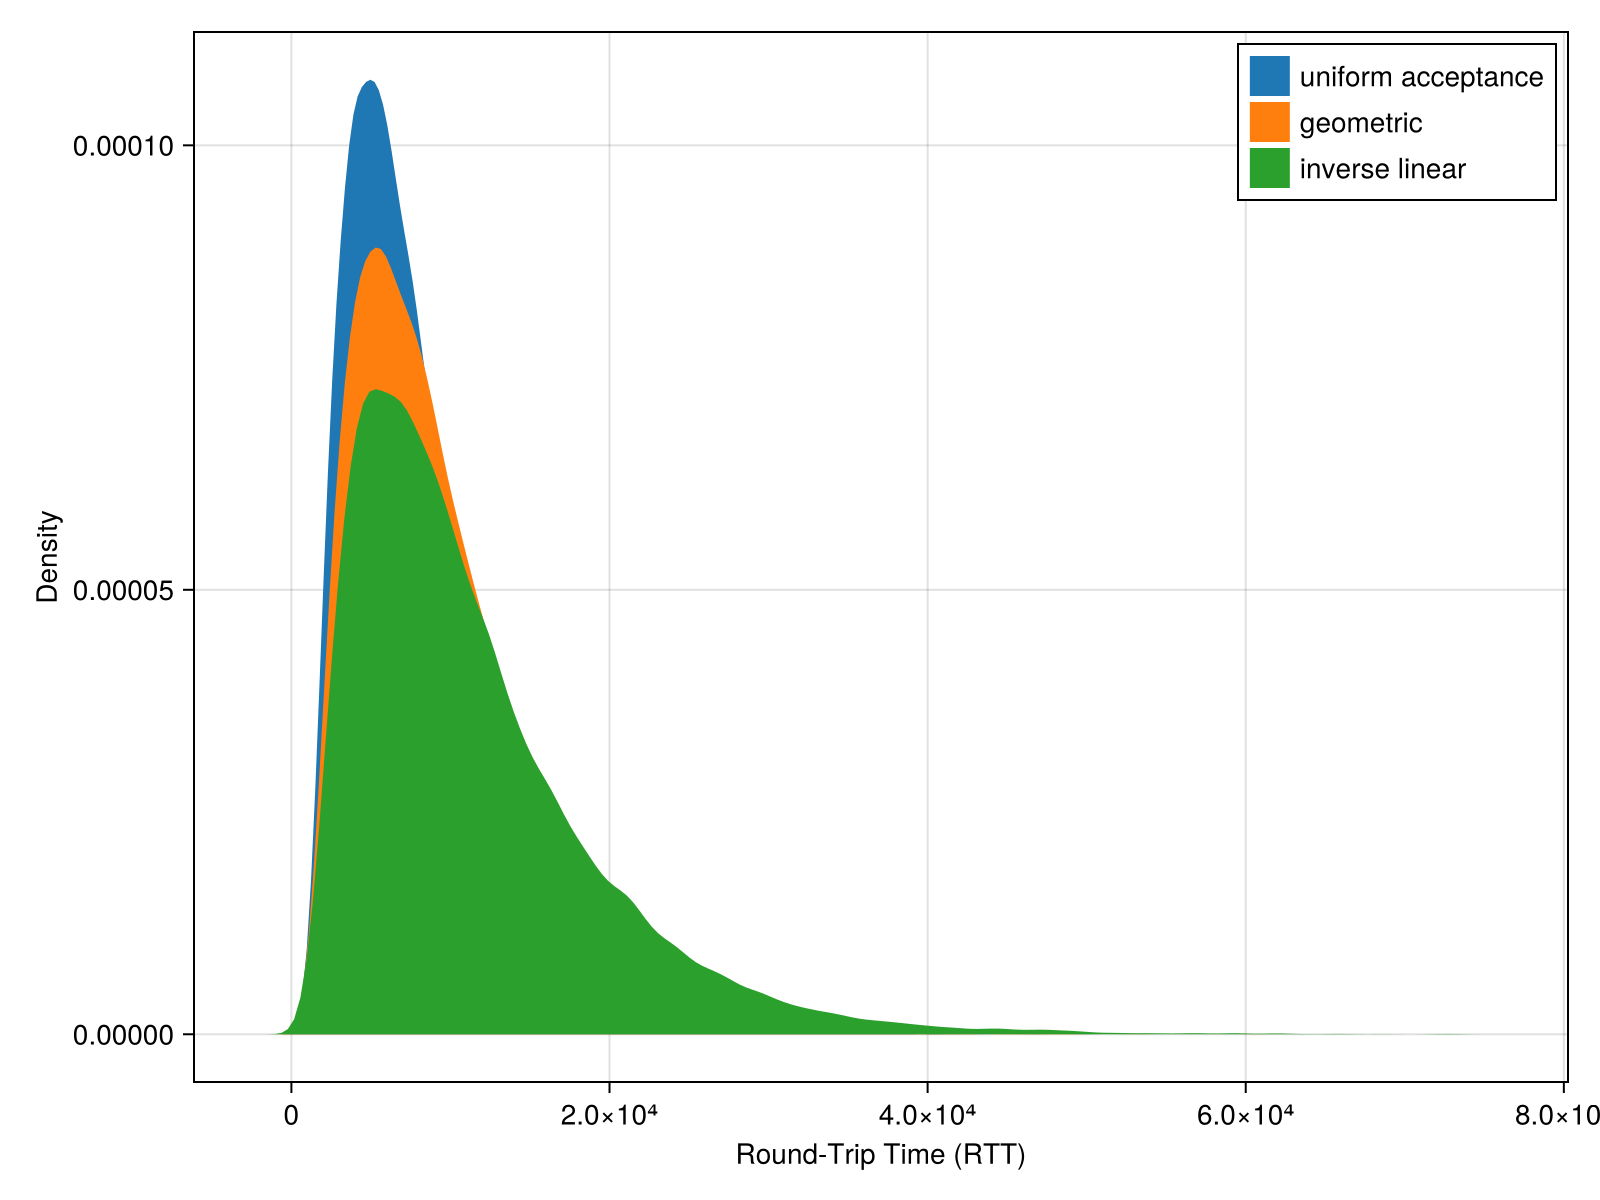

CairoMakie.Screen{IMAGE}


In [9]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
    # title="Distribution of Round-Trip Times for Different Strategies"
)
plot_colors = [colorant"#1f77b4", colorant"#ff7f0e", colorant"#2ca02c"]

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        density!(ax, rtt_results[strategy], label=strategy, color = plot_colors[i])
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

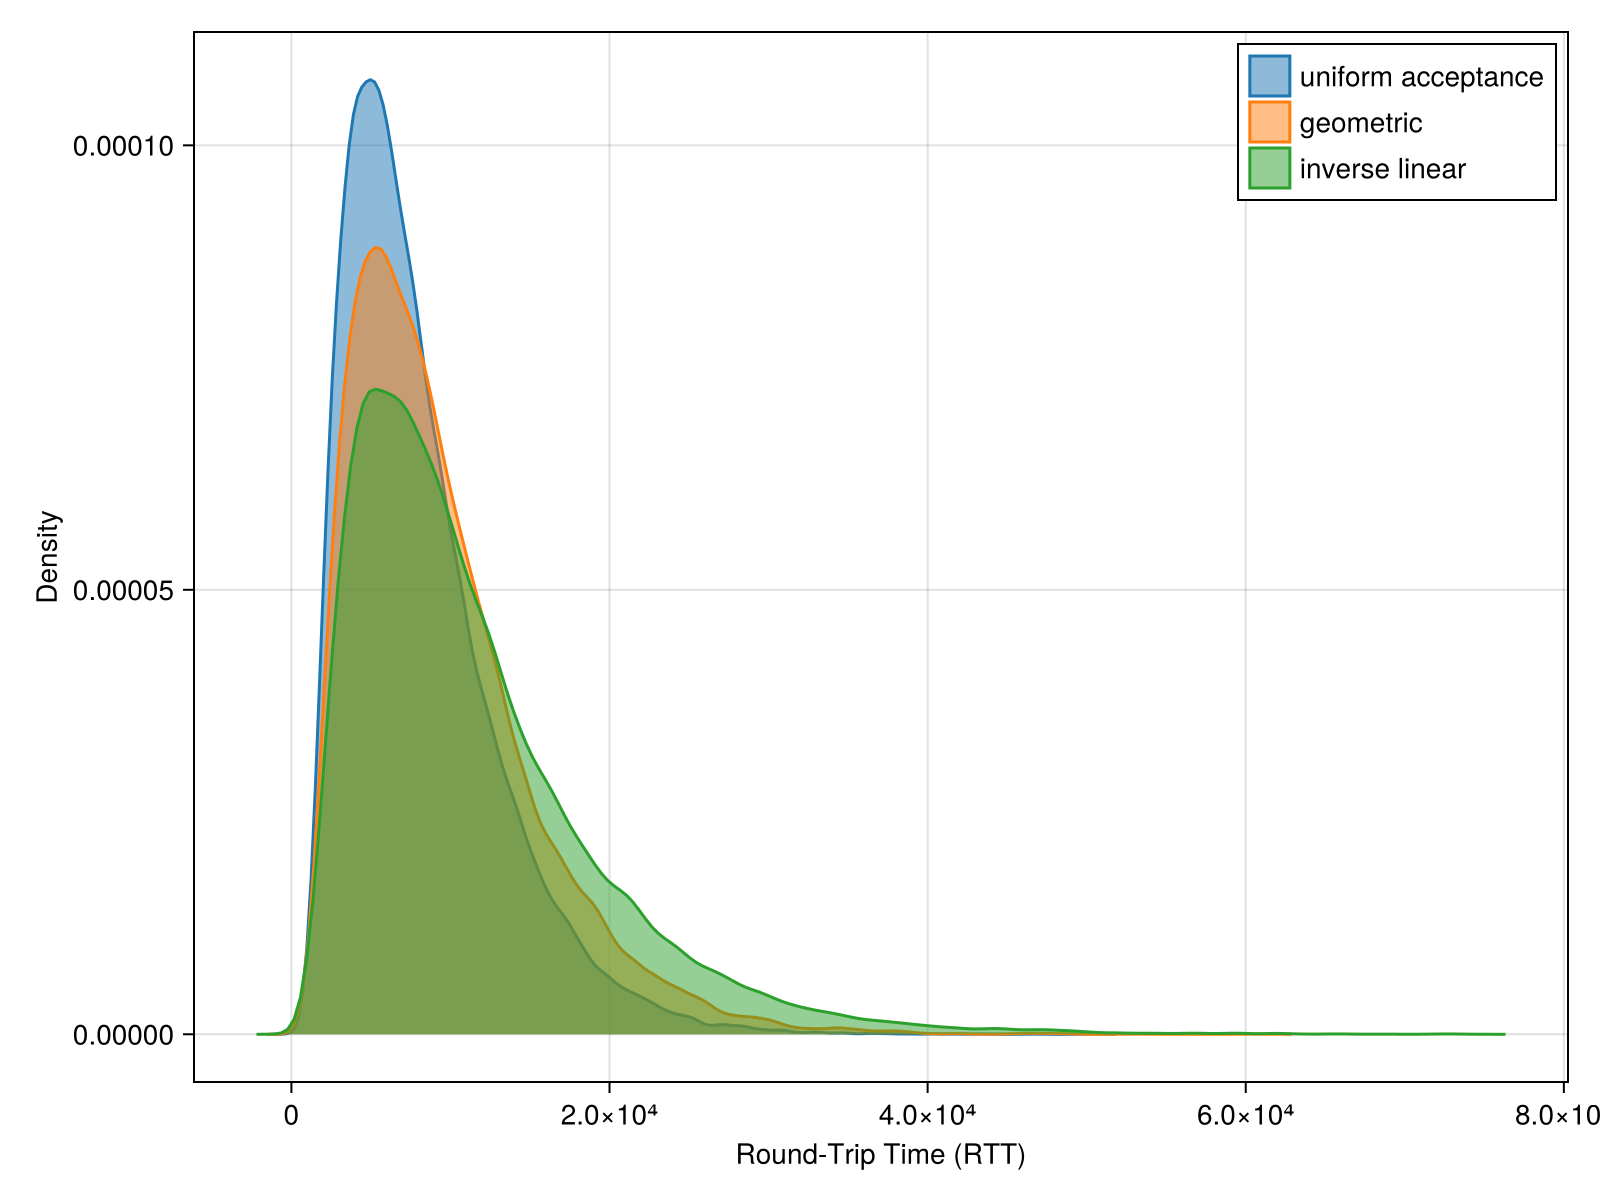

CairoMakie.Screen{IMAGE}


In [6]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
xlabel="Round-Trip Time (RTT)",
ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        density!(ax, rtt_results[strategy], 
                 label=strategy, 
                 color=(plot_colors[i], 0.5), 
                 strokecolor=(plot_colors[i], 1.0), 
                 strokewidth=1.5)
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

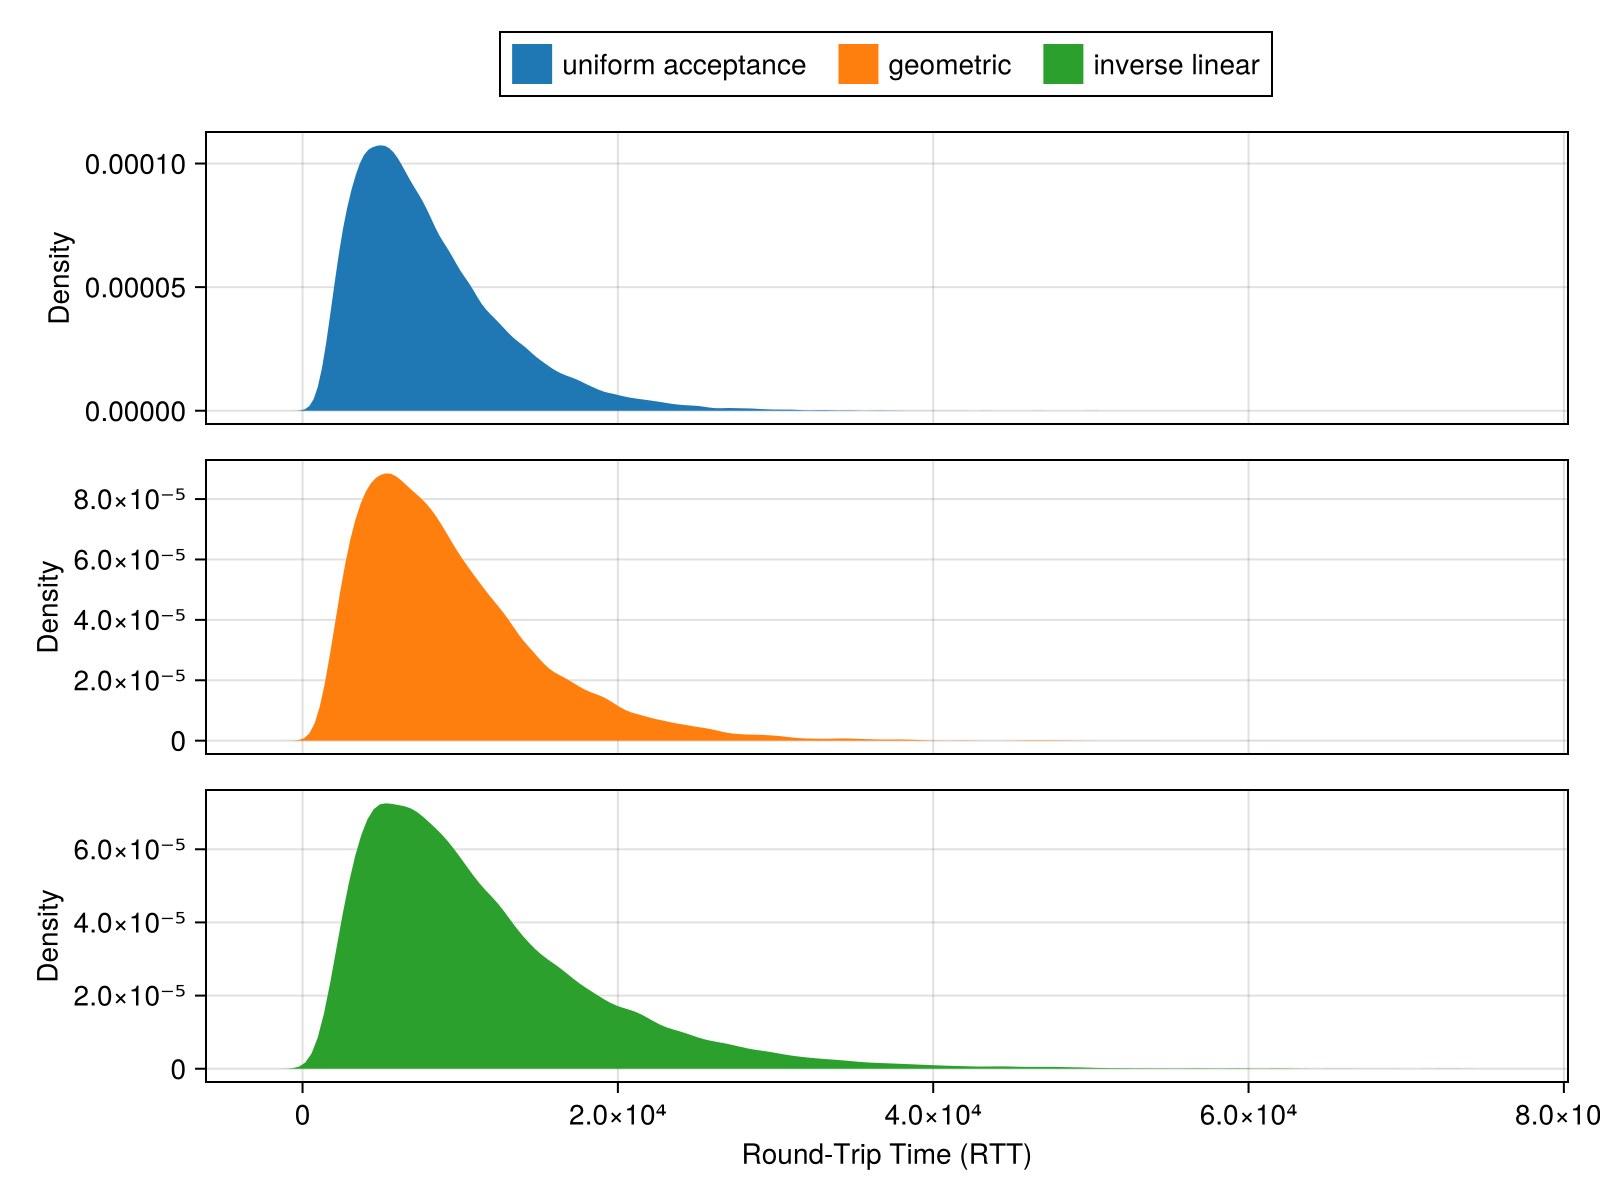

CairoMakie.Screen{IMAGE}


In [7]:
fig = Figure(size=(800, 600))
elements = []
labels = []
axes = Axis[]

for (i, strategy) in enumerate(strategies)
    ax = Axis(fig[i, 1],
        ylabel="Density",
    )
    push!(axes, ax)

    if i < length(strategies)
        hidexdecorations!(ax, grid = false)
    else
        ax.xlabel = "Round-Trip Time (RTT)"
    end
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        d = density!(ax, rtt_results[strategy], color = plot_colors[i])
        push!(elements, d)
        push!(labels, strategy)
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

Legend(fig[0, 1], elements, labels, orientation = :horizontal, halign = :center)
linkxaxes!(axes...)
display(fig)

In [8]:
for strategy in strategies
    println("""
        $strategy: 
        mean RTT = $(mean(rtt_results[strategy]))
        median RTT = $(median(rtt_results[strategy]))
        mode RTT = $(mode(rtt_results[strategy]))
        min RTT = $(minimum(rtt_results[strategy]))
        max RTT = $(maximum(rtt_results[strategy]))
        std RTT = $(std(rtt_results[strategy]))
    """)
end

    uniform acceptance: 
    mean RTT = 7988.70000603731
    median RTT = 6892.0
    mode RTT = 5728.0
    min RTT = 652.0
    max RTT = 50022.0
    std RTT = 4792.193508043548

    geometric: 
    mean RTT = 9366.673724007562
    median RTT = 8080.0
    mode RTT = 8652.0
    min RTT = 756.0
    max RTT = 60634.0
    std RTT = 5776.27326346864

    inverse linear: 
    mean RTT = 11331.048589251988
    median RTT = 9393.0
    mode RTT = 7012.0
    min RTT = 796.0
    max RTT = 73342.0
    std RTT = 7739.336097656814



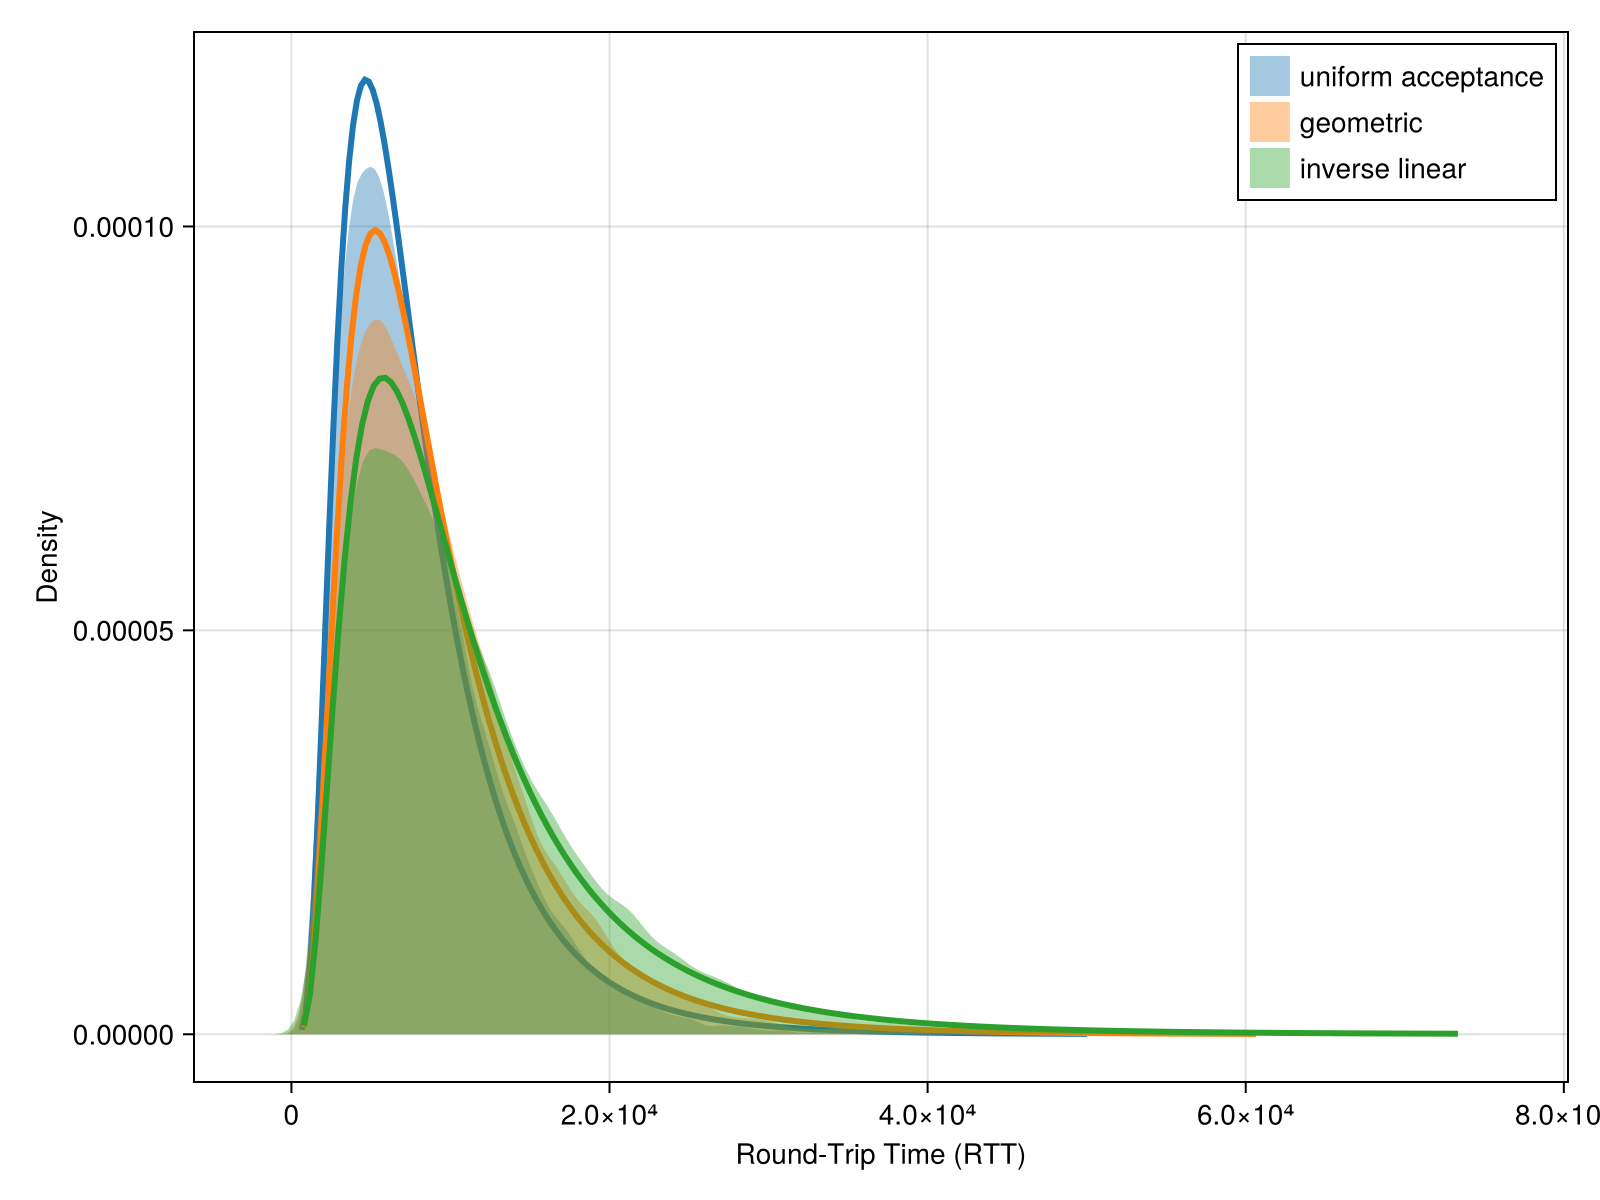

CairoMakie.Screen{IMAGE}


In [11]:
using Distributions

fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        data = rtt_results[strategy]
        
        density!(ax, data, label=strategy, color=(plot_colors[i], 0.4))
        
        fitted_dist = fit(LogNormal, data)
        
        x_range = range(minimum(data), maximum(data), length=200)
        y_values = pdf.(fitted_dist, x_range)
        lines!(ax, x_range, y_values, color=plot_colors[i], linewidth=3)
        
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)

Strategy: uniform acceptance, Fitted Gamma(α = 3.05, θ = 2616.61)
Strategy: geometric, Fitted Gamma(α = 2.87, θ = 3268.74)
Strategy: inverse linear, Fitted Gamma(α = 2.45, θ = 4615.72)


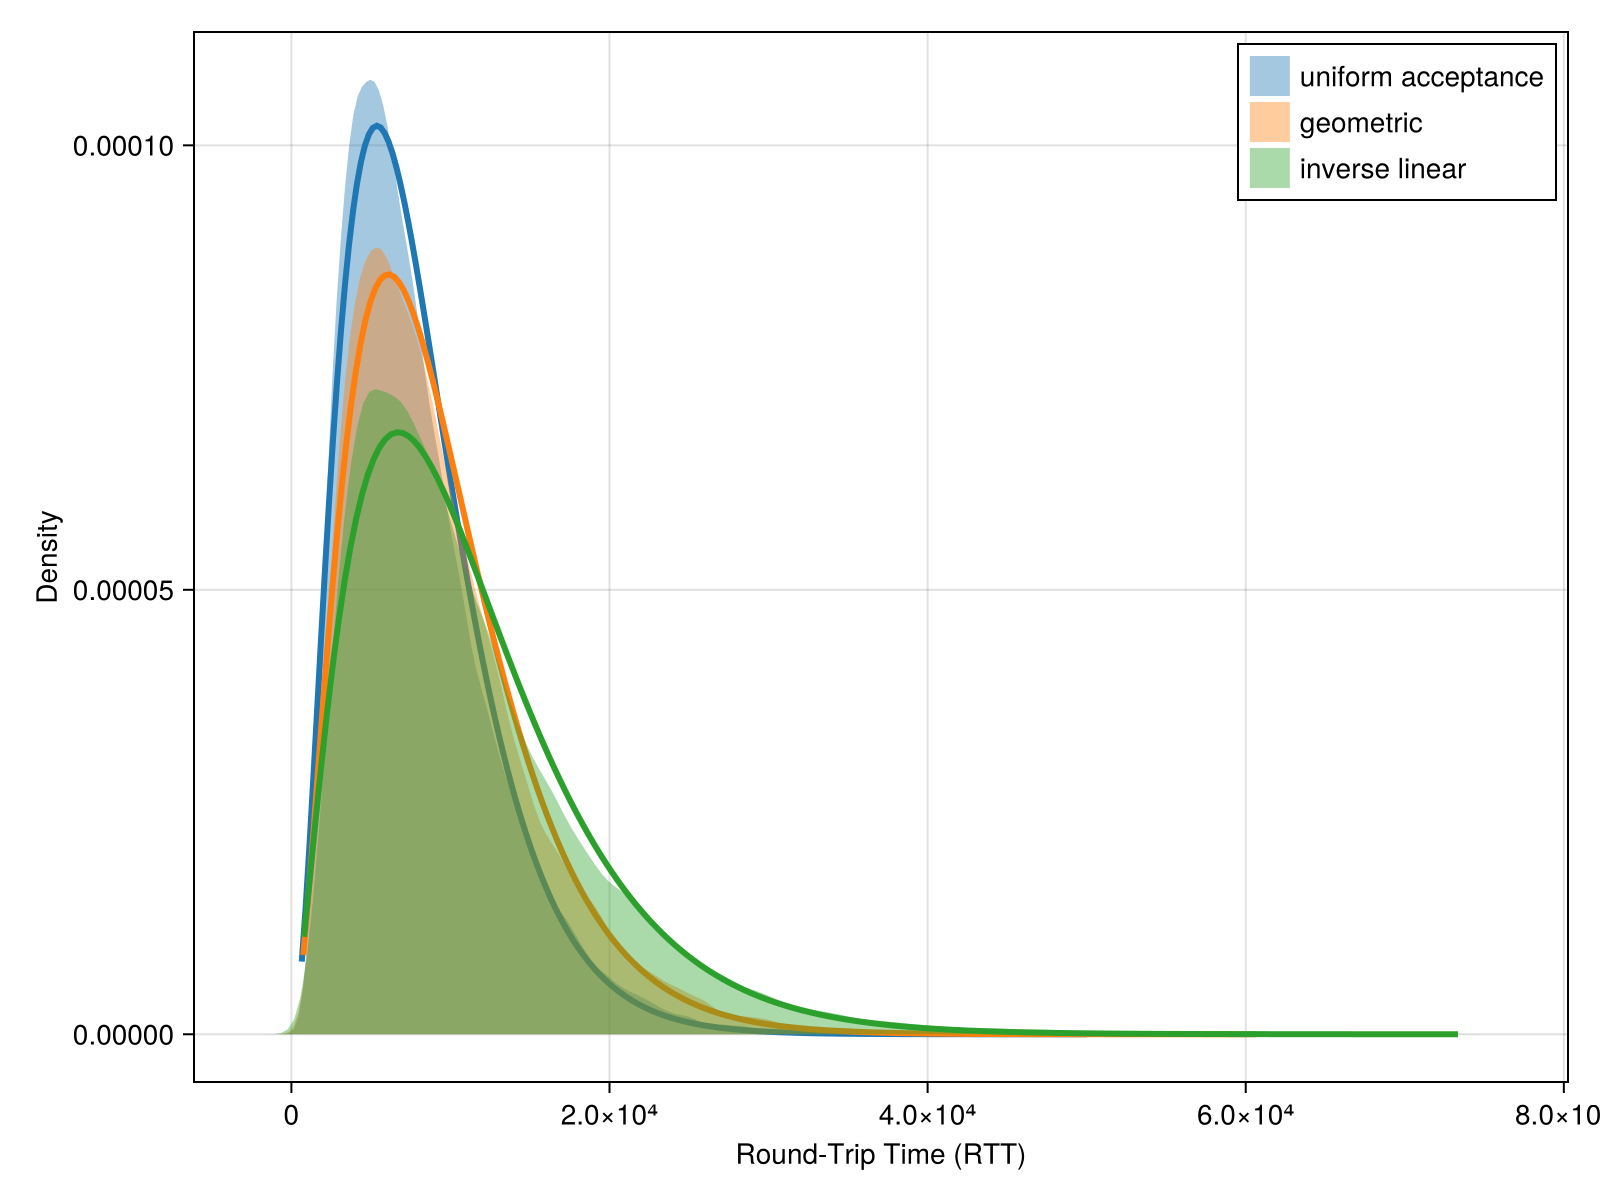

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
)

for (i, strategy) in enumerate(strategies)
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        data = rtt_results[strategy]
        
        density!(ax, data, label=strategy, color=(plot_colors[i], 0.4))
        
        fitted_dist = fit(Gamma, data)
        
        x_range = range(minimum(data), maximum(data), length=200)
        y_values = pdf.(fitted_dist, x_range)
        lines!(ax, x_range, y_values, color=plot_colors[i], linewidth=3)
        
        println("Strategy: $(strategy), Fitted Gamma(α = $(round(fitted_dist.α, digits=2)), θ = $(round(fitted_dist.θ, digits=2)))")
        
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)